# QAOA Implementation Demo
**Author: Cooper Midroni**
<br>
cooper@entropicalabs.com

In this notebook we demonstrate a start-to-finish project workflow for using QAOA to cluster a dataset. Before diving into the code, we will build some intuition for how we can turn any dataset into a format that is agreeable with QAOA's clustering-specific paradigm. 

## Understanding Maxcut

As laid out by [Rigetti's paper on QAOA](https://arxiv.org/pdf/1712.05771.pdf), there are a number of important steps that we must follow to map the problem of clustering into a format which QAOA can process. Broadly speaking, QAOA solves the **MAXCUT** problem, in which a graph of $n$ vertices is separated into two complementary subsets, $S$ and $S^{c}$, such that the number of edges between $S$ and $S^{c}$ is as large as possible.
<br>
<br>
<center><img src="imgs/maxcut.png"></center>
<center><i> A depiction of the maxcut problem, displaying a cut which separates white and black vertices.</i></center>
<br>
<br>    
This problem can be made more sophisticated by adding numerical values as <i>weights</i> to the edges, such that the best solution maximizes the sum of weights which separate $S$ and $S^{c}$. This is precisely the approach we take in using maxcut to cluster our data. 

We allow the weights associated to each edge to be some notion of distance between points. In this way, the sets dictated by our optimal cut, $S$ and $S^{c}$, separate the data into binary clusters.

From our current understanding, we can already begin to formulate some first steps in preparing our data. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data
The dataset we will use is the **Pokemon dataset**, which can be found on [Github](https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6).

We will first walk through a highly manicured example, in which we attempt to cluster Pokemon into Legendary and non-Legendary classes. In doing so, we will choose samples from each class in equal proportion.

In [2]:
df = pd.read_csv('./data/pokemon.csv')
df = df.set_index('#') 
df = df.rename_axis('ID') #reindex to the Pokemon's ID
df = df.loc[~df.index.duplicated(keep='first')] #drop duplicates
df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


To avoid too many bells and whistles, we'll stick to our roots and only consider Pokemon from the first three generations.

In [3]:
df = df.loc[df['Generation']<=3]
df.sample(frac=1).head() #sample the whole dataset to shuffle the arrangement

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
118,Goldeen,Water,NaN,320,45,67,60,35,50,63,1,False
187,Hoppip,Grass,Flying,250,35,35,40,35,55,50,2,False
256,Combusken,Fire,Fighting,405,60,85,60,85,60,55,3,False
276,Taillow,Normal,Flying,270,40,55,30,30,30,85,3,False
58,Growlithe,Fire,NaN,350,55,70,45,70,50,60,1,False


Now, randomly select 5 Legendary and 5 Non-Legendary Pokemon to act as our samples to be clustered.

In [4]:
legendary = df.loc[df['Legendary'] == True].sample(5)
non_legendary = df.loc[df['Legendary'] == False].sample(5)
pokemon = pd.concat([legendary,non_legendary])

To further simplify the problem, we will only consider numerical values in our clustering of the data.

In [5]:
numerical_columns = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']

In [6]:
labels = pokemon['Legendary']
data = pokemon[numerical_columns].copy()
data.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
ID,,,,,,,
245,580,100,75,115,90,115,85
250,680,106,130,90,110,154,90
144,580,90,85,100,95,125,85
386,600,50,150,50,150,50,150
377,580,80,100,200,50,100,50


We now use SciPy's built in `distance_matrix` function to easily turn this set of points into the desired matrix of pairwise distances. Recall, that a distance matrix can be interpretted as the adjacency matrix of a graph. 

In [7]:
from forest_qaoa.utilities import distances_dataset

In [8]:
from scipy.spatial import distance_matrix
dist = pd.DataFrame(distance_matrix(data.values,data.values,p=2),
                       index=data.index,columns=data.index)
dist

ID,245,250,144,386,377,117,12,373,55,203
ID,,,,,,,,,,
245,0.000000,125.027997,23.452079,157.480157,106.301458,164.468842,205.912603,84.261498,97.303648,146.799183
250,125.027997,0.000000,116.068945,165.987951,178.303113,276.734530,313.754681,110.553155,203.100960,251.777680
144,23.452079,116.068945,0.000000,146.969385,119.163753,166.282891,203.715488,76.157731,94.963151,144.568323
386,157.480157,165.987951,146.969385,0.000000,220.907220,205.304652,253.081015,90.277350,156.390537,186.010752
377,106.301458,178.303113,119.163753,220.907220,0.000000,196.850197,250.099980,150.831031,158.927656,195.959179
117,164.468842,276.734530,166.282891,205.304652,196.850197,0.000000,77.136243,184.390889,77.640196,44.721360
12,205.912603,313.754681,203.715488,253.081015,250.099980,77.136243,0.000000,231.408729,117.592517,74.833148
373,84.261498,110.553155,76.157731,90.277350,150.831031,184.390889,231.408729,0.000000,116.137849,160.468065
55,97.303648,203.100960,94.963151,156.390537,158.927656,77.640196,117.592517,116.137849,0.000000,50.477718


## Understanding QAOA
With an understanding of the MAXCUT structure which produces our clustered output, we ask ourselves how we can turn this graph problem into an optimization problem. To move forward, we take inspiration from statistical mechanics and model this problem through the lens of interacting spin systems. The explanation below will explain how the distance matrix above can be mapped into an [Ising Model](https://en.wikipedia.org/wiki/Ising_model), for those familiar, feel free to skip ahead.

***
###  An Ising Model Interpretation
In our terminology, a spin system is any two state system. Imagine a system composed of two dipole magnets. Let's consider a magnet to be *spin up* when its North face is raised, and *spin down* when its South face is raised. Because of the magnetic interactions between the poles of each magnet, we know that the two magnets want to anti-align.

<center><img src="imgs/magnets.png" style="height:200px"></center>
<center><i> Fig 2. A two body spin system of dipole magnets.</i></center>

We can consider this arrangement to be the *lowest energy state* of this simple two-body spin system. This system can be mathematically encoded, in the following manner:

<center>$\begin{cases} 
      spin \uparrow = +1
      \\
      spin \downarrow = -1
   \end{cases}
$</center>

Let $\sigma_{i}$ represent the spin state of magnet $i$. In this way, the energy of our system is represented by: <br><br>

<center>$Energy = \sigma_{1}\cdot\sigma_{2}$</center> 

We can see that in this arrangement, the lowest energy state corresponds to a value of $-1$. Were we to introduce another magnet to the system, we would then have to capture the relationships between all three bodies. <br><br>

<center> $\sum_{\langle i j\rangle}^{n=3} \sigma_{i} \sigma_{j} = \sigma_{1}\cdot\sigma_{2} + 
\sigma_{2}\cdot\sigma_{3} + \sigma_{1}\cdot\sigma_{3}$</center>

Much like we did in the MAXCUT configuration, we can introduce the notion of distances as an analogy to the *interaction strength* between bodies in our system. Magnets which are closer together have a greater influence on one another. Let the interaction strength between any two magnets in this system be $J_{i,j}$, evolving our model to the following form: <br><br>
<center> $\sum_{\langle i j\rangle} J_{i j} \sigma_{i}\sigma_{j}$ </center>

Finally, we introduce *biases* that can be applied on single magnets in our system to influence their state. A strong bias number will guarantee that one of our magnets is flipped to the spin $\uparrow$ or spin $\downarrow$ state. Let $\mu_{i}$ be the bias that is applied to magnet $i$. This brings us to the final state of our Classical Ising Model:<br><br>


<center> $H(\sigma)=-\sum_{\langle i j\rangle} J_{i j} \sigma_{i} \sigma_{j}-\mu \sum_{j} h_{j} \sigma_{j}$ </center>

By convention, we place a negative sign on this equation. The symbol $H$ stands for *Hamiltonian*, which, in quantum mechanics, is an operator which acts as a sum of the energies of the system.
***
## Create the Hamiltonian
To make a Hamiltonian that is recognizable by pyQuil, we must use the pyQuil `PauliTerm` object.

In [9]:
from pyquil.api import WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

To get a feel for our process, let's make a simple Hamiltonian for our three magnet system above.

In `PauliTerm`, the first argument is the operator type, the second is the qubit, and the third is the interaction strength.

In [10]:
term1 = PauliTerm("Z",0,1)*PauliTerm("Z",1,1)
term2 = PauliTerm("Z",1,1)*PauliTerm("Z",2,1)
term3 = PauliTerm("Z",0,1)*PauliTerm("Z",2,1)
hamiltonian = PauliSum([term1, term2, term3])

Play around with the numbers in the above cell and see how it influences the resulting Hamiltonian.

In [11]:
print(hamiltonian)

(1+0j)*Z0*Z1 + (1+0j)*Z1*Z2 + (1+0j)*Z0*Z2


By including single `PauliTerm`s in our `PauliSum`, we can include the effect of biases.

In [12]:
term4 = PauliTerm("Z",0,25)
term5 = PauliTerm("Z",2,25)
hamiltonian = PauliSum([term1, term2, term3,
                        term4, term5])
print(hamiltonian)

(1+0j)*Z0*Z1 + (1+0j)*Z1*Z2 + (1+0j)*Z0*Z2 + (25+0j)*Z0 + (25+0j)*Z2


We can see now that to make the Hamiltonian for our system we must iterate over each distance in our distance matrix, and assign it within a `PauliTerm` as the interaction strength between the appropriate qubits.

In [13]:
pauli_list = list()
m,n = dist.shape

#pairwise interactions
for i in range(m):
    for j in range(n):
        if i < j:
            term = PauliTerm("Z",i,dist.values[i][j])*PauliTerm("Z",j, 1.0) #we set the second term to 1, so we don't scale the distances
            pauli_list.append(term)

In [14]:
hamiltonian = PauliSum(pauli_list)
print(hamiltonian)

(125.02799686470227+0j)*Z0*Z1 + (23.45207879911715+0j)*Z0*Z2 + (157.48015748023622+0j)*Z0*Z3 + (106.30145812734649+0j)*Z0*Z4 + (164.46884203398528+0j)*Z0*Z5 + (205.91260281974002+0j)*Z0*Z6 + (84.26149773176358+0j)*Z0*Z7 + (97.30364844136113+0j)*Z0*Z8 + (146.79918255903198+0j)*Z0*Z9 + (116.06894502837527+0j)*Z1*Z2 + (165.98795136997143+0j)*Z1*Z3 + (178.30311270418136+0j)*Z1*Z4 + (276.73452982958236+0j)*Z1*Z5 + (313.7546812399777+0j)*Z1*Z6 + (110.55315463612968+0j)*Z1*Z7 + (203.100960115899+0j)*Z1*Z8 + (251.77767970969944+0j)*Z1*Z9 + (146.9693845669907+0j)*Z2*Z3 + (119.16375287812986+0j)*Z2*Z4 + (166.2828914831589+0j)*Z2*Z5 + (203.71548787463362+0j)*Z2*Z6 + (76.15773105863909+0j)*Z2*Z7 + (94.96315074806648+0j)*Z2*Z8 + (144.5683229480096+0j)*Z2*Z9 + (220.90722034374522+0j)*Z3*Z4 + (205.3046516764781+0j)*Z3*Z5 + (253.0810146968753+0j)*Z3*Z6 + (90.27735042633894+0j)*Z3*Z7 + (156.3905367981068+0j)*Z3*Z8 + (186.01075237738274+0j)*Z3*Z9 + (196.85019685029528+0j)*Z4*Z5 + (250.099980007996+0j)*Z

The above exercise brings up an important limitation to our present QAOA approach. The number of datapoints we are able to use is limited by the number of qubits we have available.

## From Hamiltonian To Clusters
<br>
<br>
<center><img src="imgs/spins.png"style="width:200px"></center>
<center><i> A depiction of the maxcut problem, displaying a cut which separates white and black vertices.</i></center>
<br>
<br>  



It is possible to take inspiration from stati

'optimize' such a problem to result in the best possible cut. 

## Apply QAOA

In [15]:
# import the neccesary pyquil modules
from forest_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

# import the QAOAParameters that we want to demo
from forest_qaoa.qaoa.parameters import GeneralQAOAParameters
from forest_qaoa.vqe.optimizer import scipy_optimizer

#Some utilities for time tracking and measuring our outcomes.
import time
from math import log
from sklearn.metrics import accuracy_score

### Choose the Problem Hyperparameters

In [16]:
timesteps = 3
end_time = 1
iters = 500
num_q = 10 #this number might be defined before your dataset
#The hamiltonian is also a hyperparameter

### Generate Parameters
In this QAOA run, we will use `GeneralQAOAParameters`. This parameter class provides the most degrees of freedom for our optimizer to explore the energy landscape. Conversely, it also has the most parameters to optimize and thus will take longer to converge. 

To insantiate this parameter class, we need to pass in three separate lists of angles.
- $\vec{\beta}$: every timestep requires 'nqubit' beta rotations. Thus there are $nqubit\cdot timestep$ beta values.
- $\vec{\gamma}_{pairs}$: there is a gamma rotation for every two-qubit interaction. A simple way to come up with this number is to measure the length of your hamiltonian subtracted by the number of single qubit bias terms in place.
- $\vec{\gamma}_{singles}$: there is a gamma single rotation for each bias term included in the hamiltonian.

We randomly generate these lists as their initial starting states are somewhat redunant. They will be optimized over 100s of iterations!

In [17]:
betas = [round(val,1) for val in np.random.rand(timesteps*num_q)]
gammas_singles = [round(val,1) for val in np.random.rand(0)] #we don't want any bias terms
gammas_pairs = [round(val,1) for val in np.random.rand(timesteps*len(hamiltonian))]

hyperparameters = (hamiltonian, timesteps)
parameters = (betas, gammas_singles, gammas_pairs)

params = GeneralQAOAParameters(hyperparameters, parameters)

Before starting the simulator, make sure you are running rigetti's QVM and Quil Compiler
### First QAOA Run: 3 Timesteps, 500 Iterations

In [18]:
# Set up the WavefunctionSimulator from pyQuil
sim = WavefunctionSimulator()
cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                            params=params,
                                            sim=sim,
                                            return_standard_deviation=True,
                                            noisy=False,
                                            log=[])

In [19]:
t0 = time.time()
res = scipy_optimizer(cost_function, params.raw(), epsilon=1e-3,
                          maxiter=iters)
print('Run complete!\n','Runtime:','{:.3f}'.format(time.time()-t0))

Run complete
 Runtime: 27.299


In [20]:
def return_lowest_state(probs):
    index_max = max(range(len(probs)), key=probs.__getitem__)
    string = '{0:0'+str(int(log(len(probs),2)))+'b}'
    string = string.format(index_max)
    return [int(item) for item in string]

In [26]:
type(wave_func)

pyquil.wavefunction.Wavefunction

In [21]:
wave_func = cost_function.get_wavefunction(params.raw())
lowest = return_lowest_state(wave_func.probabilities())

In [22]:
true_clusters = [1 if val else 0 for val in labels] 
print('True Labels of samples:',true_clusters)
print('Lowest QAOA State:',lowest)

from sklearn.metrics import accuracy_score
acc = accuracy_score(lowest,true_clusters)
print('Accuracy of Original State:',acc*100,'%')

#Account for the complement bit string in case a class-swap
final_c = [0 if item == 1 else 1 for item in lowest]

acc_c = accuracy_score(final_c,true_clusters)
print('Accuracy of Complement State:',acc_c*100,'%')

True Labels of samples: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Lowest QAOA State: [0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Accuracy of Original State: 60.0 %
Accuracy of Complement State: 40.0 %


We can analyze the optimizer to see whether or not our QAOA run converged. For the full message, run:
```python
print(res)
```

In [23]:
print('Cost Function Value:', res.fun)
print('Converged?:',res.message)

Cost Function Value: -260.4190156598098
Converged?: Maximum number of function evaluations has been exceeded.


We can see we did not converge. Let's tighten up our operations by wrapping our QAOA runs in a function and increase the number of iterations.

In [21]:
def run_qaoa(hamiltonian,params, timesteps=2,end_time=1,max_iters=150,init_state=None):    
    sim = WavefunctionSimulator()
    cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                            params=params,
                                            sim=sim,
                                            return_standard_deviation=True,
                                            noisy=False,
                                            log=[],
                                            init_state=init_state)
    
    res = scipy_optimizer(cost_function, params.raw(), epsilon=1e-3,
                          maxiter=max_iters)
    
    return cost_function.get_wavefunction(params.raw()), res


In [23]:
t0 = time.time()
wave_func , res = run_qaoa(hamiltonian,params,timesteps=2,max_iters=1000)
print('Run complete\n','Runtime:','{:.3f}'.format(time.time()-t0))

Run complete
 Runtime: 55.529


In [24]:
lowest = return_lowest_state(wave_func.probabilities())

In [25]:
true_clusters = [1 if val else 0 for val in labels] 
print('True Labels of samples:',true_clusters)
print('Lowest QAOA State:',lowest)

from sklearn.metrics import accuracy_score
acc = accuracy_score(lowest,true_clusters)
print('Accuracy of Original State:',acc*100,'%')

#Account for the complement bit string in case a class-swap
final_c = [0 if item == 1 else 1 for item in lowest]

acc_c = accuracy_score(final_c,true_clusters)
print('Accuracy of Complement State:',acc_c*100,'%')

True Labels of samples: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Lowest QAOA State: [0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
Accuracy of Original State: 20.0 %
Accuracy of Complement State: 80.0 %


In [26]:
df.loc[data.index]

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
ID,,,,,,,,,,,,
377,Regirock,Rock,NaN,580,80,100,200,50,100,50,3,True
150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
245,Suicune,Water,NaN,580,100,75,115,90,115,85,2,True
385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True
14,Kakuna,Bug,Poison,205,45,25,50,25,25,35,1,False
317,Swalot,Poison,NaN,467,100,73,83,73,83,55,3,False
41,Zubat,Poison,Flying,245,40,45,35,30,40,55,1,False
280,Ralts,Psychic,Fairy,198,28,25,25,45,35,40,3,False


Your own performance will vary based on which Pokemon were randomly selected from each class. Results can be improved. 

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=5).fit(data)

In [29]:
PCA(n_components=5).fit(data).explained_variance_

array([37889.92159586,  2202.45202678,   241.04617535,   132.15040666,
          70.80992128])

In [30]:
def pca_results(data, pca):    
    # Dimension indexing
    dimensions = ['PC-{}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
    
    plt.subplots_adjust(top=0.9)
    
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

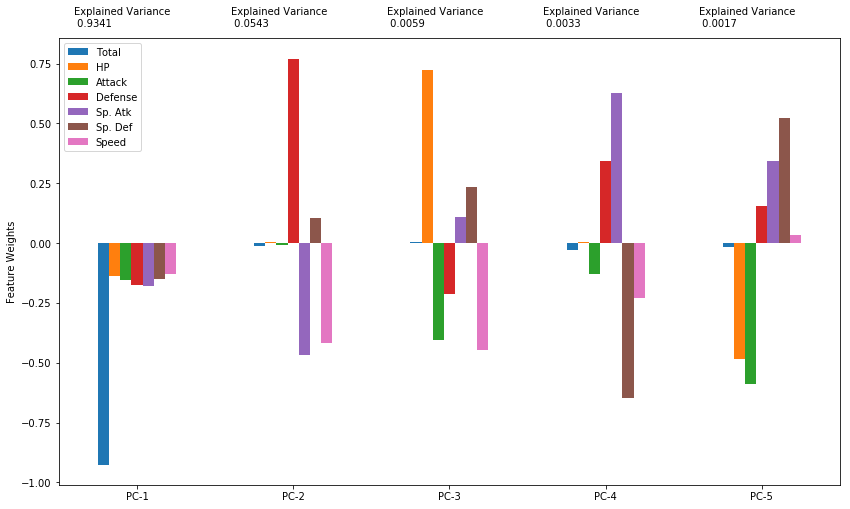

In [31]:
pca_results = pca_results(data, pca)

In [32]:
pca_results.cumsum()

,Explained Variance,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
PC-1,0.9341,-0.9249,-0.1363,-0.1544,-0.1759,-0.1780,-0.1501,-0.1302
PC-2,0.9884,-0.9389,-0.1321,-0.1609,0.5947,-0.6473,-0.0451,-0.5481
PC-3,0.9943,-0.9340,0.5920,-0.5652,0.3807,-0.5370,0.1898,-0.9942
PC-4,0.9976,-0.9623,0.5948,-0.6959,0.7259,0.0908,-0.4559,-1.2219
PC-5,0.9993,-0.9782,0.1106,-1.2852,0.8806,0.4354,0.0677,-1.1873


# Experimental

In [33]:
#This function can create the loading plot from PCA along any PCs indicated in components = list()
def loading_plot_color(reduced_data, pca, components=[1,2]):
    fig, ax = plt.subplots(figsize = (10,8))
    # scatterplot of the reduced data 
    pc1 = 'PC-'+str(components[0])
    pc2 = 'PC-'+str(components[1])
    
    coords_x0, coords_x1, coords_y0, coords_y1 = list(), list(), list(), list()
    
    for i, target in enumerate(reduced_data['label']):
        if target == 0:
            print('yes')
            coords_x0.append(reduced_data.loc[:,pc1][i])
            coords_y0.append(reduced_data.loc[:,pc2][i])
        else:
            coords_x1.append(reduced_data.loc[:,pc1][i])
            coords_y1.append(reduced_data.loc[:,pc2][i])
    
    #Plot class 0
    ax.scatter(x=coords_x0, y=coords_y0, 
               edgecolors='b',color='blue', s=70, alpha=0.75)
    
    #Plot class 1
    ax.scatter(x=coords_x1, y=coords_y1, 
               edgecolors='g',color='green', s=70, alpha=0.75)

    feature_vectors = pca.components_.T
    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[components[0]-1], arrow_size*v[components[1]-1], head_width=0.2, head_length=0.15, linewidth=1, color='red',alpha=0.5)
        ax.text(v[components[0]-1]*text_pos, v[components[1]-1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)
        
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_xlabel(pc1, fontsize=14)
    ax.set_ylabel(pc2, fontsize=14)
    ax.set_title("Feature projection along the " + pc1 + ' by ' +pc2 + ' plane.', fontsize=16);
    plt.subplots_adjust(top=0.9)
    plt.show()
    return ax

In [34]:
pca = PCA(n_components = 6)
reduced_data = pd.DataFrame(pca.fit_transform(data), 
                            columns = ['PC-{}'.format(i) for i in range(1,len(pca.components_)+1)])
reduced_data['label'] = [1 if val else 0 for val in labels.values]

yes
yes
yes
yes
yes


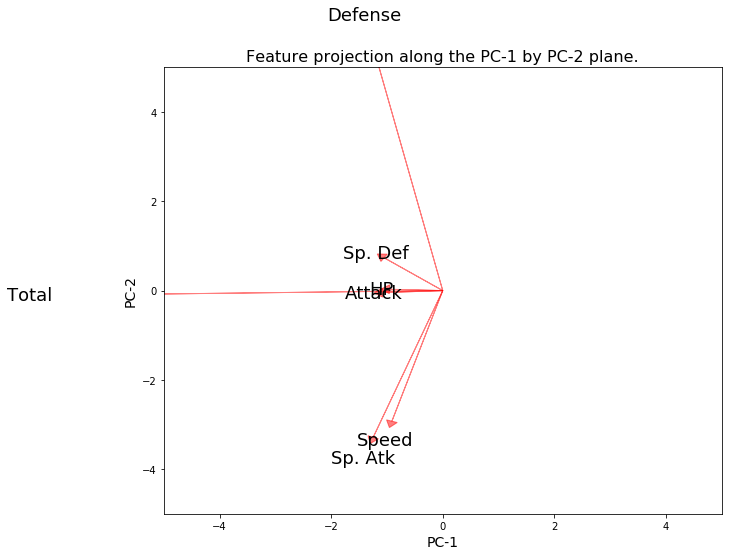

In [35]:
loading_plot_color(reduced_data, pca);